# Importing Libraries

In [42]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support, average_precision_score, ndcg_score

# Loading the Data

In [43]:
df_bg = pd.read_csv('../datasets/games-cleaned.csv')
df_rv = pd.read_csv('../datasets/reviews-cleaned.csv')

# Content-based Recommenders

In [44]:
df_bg.head()

,id,name,rank,geek_rating,avg_rating,usersrated,category,mechanic,weight,minplayers,maxplayers,playingtime,minage,yearpublished,designer,artist,publisher,description,image
0,30549,Pandemic,106,7.48669,7.58896,109006,['Medical'],"['Action Points', 'Cooperative Game', 'Hand Ma...",2.4063,2,4,45,8,2008,['Matt Leacock'],"['Josh Cappel', 'Christian Hanisch', 'Régis Mo...","['Z-Man Games', 'Albi', 'Asmodee', 'Asmodee It...","In Pandemic, several virulent diseases have br...",https://cf.geekdo-images.com/S3ybV1LAp-8SnHIXL...
1,822,Carcassonne,191,7.30857,7.41837,108776,"['City Building', 'Medieval', 'Territory Build...","['Area Majority / Influence', 'Map Addition', ...",1.9057,2,5,45,7,2000,['Klaus-Jürgen Wrede'],"['Doris Matthäus', 'Anne Pätzke', 'Chris Quill...","['Hans im Glück', '999 Games', 'Albi', 'Bard C...",Carcassonne is a tile-placement game in which ...,https://cf.geekdo-images.com/okM0dq_bEXnbyQTOv...
2,13,Catan,429,6.96965,7.13598,108064,"['Economic', 'Negotiation']","['Dice Rolling', 'Hexagon Grid', 'Income', 'Mo...",2.3130,3,4,120,10,1995,['Klaus Teuber'],"['Volkan Baga', 'Tanja Donner', 'Pete Fenlon',...","['KOSMOS', '999 Games', 'Albi', 'Asmodee', 'As...","In CATAN (formerly The Settlers of Catan), pla...",https://cf.geekdo-images.com/W3Bsga_uLP9kO91gZ...
3,68448,7 Wonders,73,7.63355,7.73515,90021,"['Ancient', 'Card Game', 'City Building', 'Civ...","['Drafting', 'Hand Management', 'Set Collectio...",2.3264,2,7,30,10,2010,['Antoine Bauza'],"['Dimitri Chappuis', 'Miguel Coimbra', 'Etienn...","['Repos Production', 'ADC Blackfire Entertainm...",You are the leader of one of the 7 great citie...,https://cf.geekdo-images.com/RvFVTEpnbb4NM7k0I...
4,36218,Dominion,104,7.49912,7.61000,81582,"['Card Game', 'Medieval']","['Deck, Bag, and Pool Building', 'Delayed Purc...",2.3542,2,4,30,13,2008,['Donald X. Vaccarino'],"['Matthias Catrein', 'Julien Delval', 'Tomasz ...","['Rio Grande Games', '999 Games', 'Albi', 'Bar...","&quot;You are a monarch, like your parents bef...",https://cf.geekdo-images.com/j6iQpZ4XkemZP07HN...


In [45]:
df_rv.head()

,user,name,rating
0,1 Family Meeple,10 Days in Europe,4.1
1,1 Family Meeple,12 Days,7.0
2,1 Family Meeple,7 Wonders,6.5
3,1 Family Meeple,A Column of Fire,5.0
4,1 Family Meeple,A Feast for Odin,10.0


In [46]:
print("df_bg",df_bg.shape)
print("df_rv",df_rv.shape)

df_bg (4582, 19)
df_rv (2018715, 3)


In [47]:
df_rv_rate = df_rv.set_index('user').copy()
df_rv_rate = df_rv_rate.groupby(['user', 'name']).mean()
all_users = list(df_rv_rate.index.get_level_values('user').unique())

df_rv_rate

rating
user            name                                  
1 Family Meeple 10 Days in Europe                  4.1
                12 Days                            7.0
                7 Wonders                          6.5
                A Column of Fire                   5.0
                A Feast for Odin                  10.0
...                                                ...
zuzusdad        Wreck Raiders                      9.2
                XCOM: The Board Game               8.4
                Xia: Legends of a Drift System     6.5
                Zombie Dice                        7.0
                Zooloretto                         9.9

[2018715 rows x 1 columns]

In [48]:
def evaluate(content_sim):
  df_eval = pd.DataFrame()

  for user in all_users:
    # dataframe of favourite games
    df_user = df_rv_rate.loc[user]
    avg = df_user['rating'].mean()
    df_fav = df_user[df_user['rating'] >= avg]  

    # most favourite game
    game_fav = df_fav['rating'].idxmax()

    # top 10 similar games
    df_sim = content_sim[game_fav].sort_values(ascending=False)[1:11]

    # create lists to store the true and predicted labels for precision and recall
    true_labels = []
    pred_labels = []

    # create lists to store the true and predicted labels for ndcg
    y_true = []
    y_pred = []

    for game,sim in df_sim.iteritems():
      y_pred.append(sim)
      # if the recommendation is in the user's preferred games, it is a true positive
      if game in df_fav.index:
        true_labels.append(1)
        pred_labels.append(1)
        y_true.append(df_user.loc[game]['rating'])
        
      # if the recommendation is not in the user's preferred games, it is a false positive
      else:
        true_labels.append(0)
        pred_labels.append(1)
        y_true.append(0)

    # for each game in the user's preferred games, check if it was recommended
    for game,rate in df_fav.itertuples():
      if game not in df_sim:
        true_labels.append(1)
        pred_labels.append(0)
        y_pred.append(0)
        y_true.append(df_user.loc[game]['rating'])

    # calculate precision and recall
    precision, recall, _, _ = precision_recall_fscore_support(y_true=true_labels, y_pred=pred_labels, average='binary')
    # map = average_precision_score(true_labels, y_pred)
    ndcg = ndcg_score([y_true],[y_pred], k=10, ignore_ties=True)

    # dataframe evaluate
    df_eval[user] = {'precision': f'{precision:.2f}', 'recall': f'{recall:.4f}', 'ndcg': f'{ndcg:.4f}'}
    # df_eval[user] = {'precision': f'{precision:.2f}', 'recall': f'{recall:.4f}', 'map': f'{map:.4f}', 'ndcg': f'{ndcg:.4f}'}

  df_eval = df_eval.T
  return df_eval

In [49]:
def plot_eval(df_eval):
    plt.figure(figsize=(22,6))

    plt.subplot(1,3,1)
    plt.title("Precision Plot")
    sns.distplot(df_eval['precision'])

    plt.subplot(1,3,2)
    plt.title("Recall Plot")
    sns.distplot(df_eval['recall'])

    plt.subplot(1,3,3)
    plt.title("NDCG Plot")
    sns.distplot(df_eval['ndcg'])

    plt.show()

**Recommend by Numerical Data**

In [50]:
df_bg_num = df_bg[['name', 'rank', 'weight', 'minplayers', 'maxplayers', 'playingtime', 'minage','yearpublished']].copy()

df_bg_num = df_bg_num.set_index('name')
df_bg_num.head()

,rank,weight,minplayers,maxplayers,playingtime,minage,yearpublished
name,,,,,,,
Pandemic,106,2.4063,2,4,45,8,2008
Carcassonne,191,1.9057,2,5,45,7,2000
Catan,429,2.3130,3,4,120,10,1995
7 Wonders,73,2.3264,2,7,30,10,2010
Dominion,104,2.3542,2,4,30,13,2008


In [51]:
scaler = MinMaxScaler()
num_vars = ['rank', 'weight', 'minplayers', 'maxplayers', 'playingtime', 'minage','yearpublished']
df_bg[num_vars] = scaler.fit_transform(df_bg[num_vars])

df_bg_num = df_bg[['name', 'rank', 'weight', 'minplayers', 'maxplayers', 'playingtime', 'minage','yearpublished']].copy()
df_bg_num = df_bg_num.set_index('name')
df_bg_num.head()

,rank,weight,minplayers,maxplayers,playingtime,minage,yearpublished
name,,,,,,,
Pandemic,0.017526,0.365776,0.142857,0.04,0.012500,0.444444,0.481481
Carcassonne,0.031714,0.235571,0.142857,0.05,0.012500,0.388889,0.185185
Catan,0.071440,0.341509,0.285714,0.04,0.033333,0.555556,0.000000
7 Wonders,0.012018,0.344994,0.142857,0.07,0.008333,0.555556,0.555556
Dominion,0.017192,0.352225,0.142857,0.04,0.008333,0.722222,0.481481


In [52]:
content_sim_df = pd.DataFrame(cosine_similarity(df_bg_num), columns=df_bg_num.index, index=df_bg_num.index)
content_sim_df.head()

name,Pandemic,Carcassonne,Catan,7 Wonders,Dominion,Ticket to Ride,Codenames,Terraforming Mars,7 Wonders Duel,Agricola,...,RRR,Magic: The Gathering – Heroes of Dominaria Board Game,"Gulf, Mobile & Ohio",1805: Sea of Glory,Steam Donkey,Feierabend,Nations at War: White Star Rising,Oaxaca: Crafts of a Culture,A Gentle Rain,Wizards of the Wild
name,,,,,,,,,,,,,,,,,,,,,
Pandemic,1.000000,0.942337,0.757551,0.994280,0.969871,0.976991,0.903307,0.981500,0.978808,0.944418,...,0.694616,0.787743,0.571868,0.831530,0.712002,0.826156,0.806373,0.758252,0.735394,0.705896
Carcassonne,0.942337,1.000000,0.925849,0.944817,0.974706,0.976706,0.859113,0.894535,0.882673,0.930553,...,0.686122,0.754773,0.495196,0.834676,0.676943,0.747605,0.825353,0.679008,0.607544,0.652489
Catan,0.757551,0.925849,1.000000,0.752497,0.830839,0.829943,0.642776,0.676334,0.646986,0.802479,...,0.574241,0.600616,0.399415,0.747721,0.539621,0.540036,0.716528,0.481200,0.354735,0.488213
7 Wonders,0.994280,0.944817,0.752497,1.000000,0.982789,0.987916,0.941447,0.977897,0.986140,0.929924,...,0.697751,0.795112,0.525754,0.810622,0.712276,0.834225,0.815317,0.765331,0.752278,0.711626
Dominion,0.969871,0.974706,0.830839,0.982789,1.000000,0.993751,0.936869,0.949978,0.949363,0.937085,...,0.691901,0.781864,0.454463,0.810427,0.691625,0.803086,0.839483,0.731537,0.697456,0.689052


In [53]:
df_eval = evaluate(content_sim_df)
print("Precision Average:",pd.to_numeric(df_eval['precision']).mean())
print("Recall Average:",pd.to_numeric(df_eval['recall']).mean())
print("NDCG:",pd.to_numeric(df_eval['ndcg']).mean())

Precision Average: 0.3524616889468536
Recall Average: 0.011056895989566353
NDCG: 0.30627515487447016


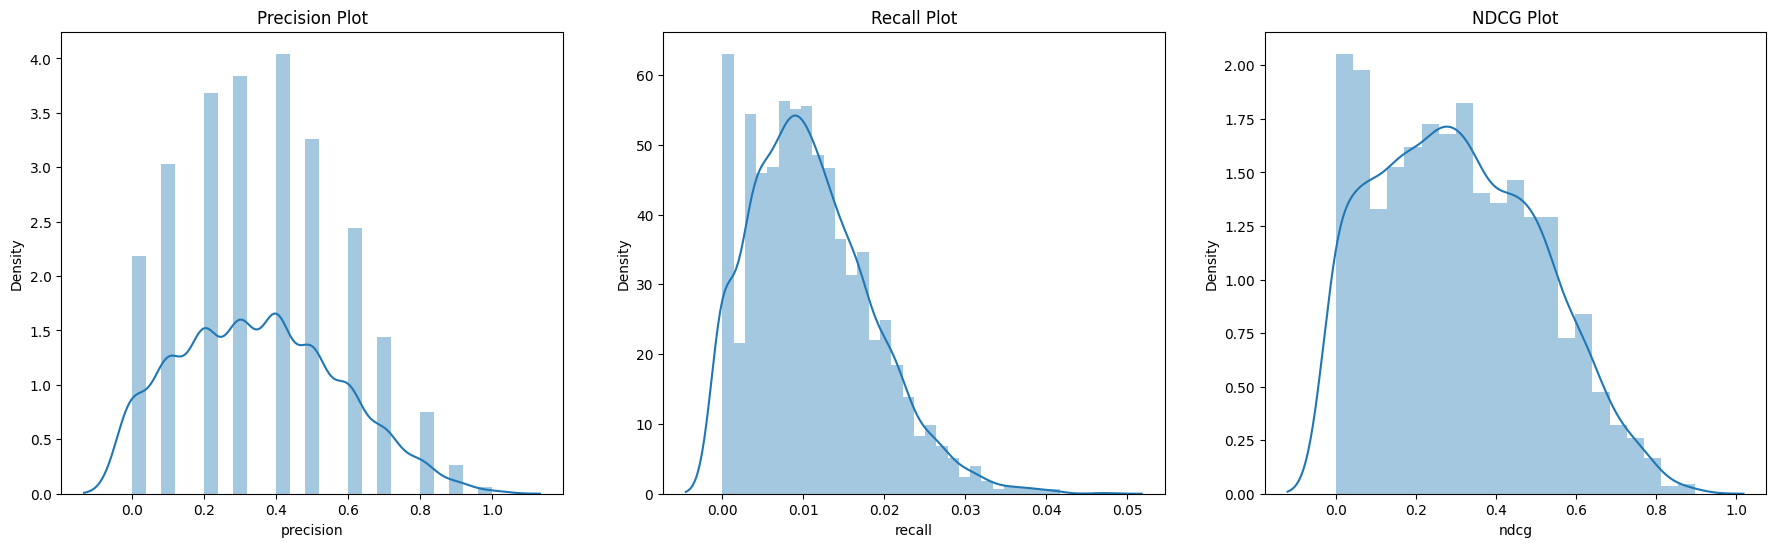

In [54]:
plot_eval(df_eval)

**Recommend by all Category Data**

In [55]:
df_bg_cat = df_bg[['name', 'category', 'mechanic', 'designer', 'artist', 'publisher']].copy()

df_bg_cat = df_bg_cat.set_index('name')
df_bg_cat.head()

,category,mechanic,designer,artist,publisher
name,,,,,
Pandemic,['Medical'],"['Action Points', 'Cooperative Game', 'Hand Ma...",['Matt Leacock'],"['Josh Cappel', 'Christian Hanisch', 'Régis Mo...","['Z-Man Games', 'Albi', 'Asmodee', 'Asmodee It..."
Carcassonne,"['City Building', 'Medieval', 'Territory Build...","['Area Majority / Influence', 'Map Addition', ...",['Klaus-Jürgen Wrede'],"['Doris Matthäus', 'Anne Pätzke', 'Chris Quill...","['Hans im Glück', '999 Games', 'Albi', 'Bard C..."
Catan,"['Economic', 'Negotiation']","['Dice Rolling', 'Hexagon Grid', 'Income', 'Mo...",['Klaus Teuber'],"['Volkan Baga', 'Tanja Donner', 'Pete Fenlon',...","['KOSMOS', '999 Games', 'Albi', 'Asmodee', 'As..."
7 Wonders,"['Ancient', 'Card Game', 'City Building', 'Civ...","['Drafting', 'Hand Management', 'Set Collectio...",['Antoine Bauza'],"['Dimitri Chappuis', 'Miguel Coimbra', 'Etienn...","['Repos Production', 'ADC Blackfire Entertainm..."
Dominion,"['Card Game', 'Medieval']","['Deck, Bag, and Pool Building', 'Delayed Purc...",['Donald X. Vaccarino'],"['Matthias Catrein', 'Julien Delval', 'Tomasz ...","['Rio Grande Games', '999 Games', 'Albi', 'Bar..."


In [56]:
# Defining the map function
def dummies(col,df):
    df[col] = df[col].str.strip('[]')
    df[col] = df[col].str.replace(" ", '')

    dummy = pd.get_dummies(df[col].str.split(',', expand=True), prefix='', prefix_sep='', drop_first = True).sum(level=0, axis=1)
    df = pd.concat([df, dummy], axis = 1)

    df.drop([col], axis = 1, inplace = True)
    return df
    
df_dummy = df_bg_cat.copy()

for col in df_bg_cat.columns:
    df_dummy = dummies(col,df_dummy)

df_dummy.head()

,'AbstractStrategy','Action/Dexterity','Adventure','AgeofReason','AmericanCivilWar','AmericanIndianWars','AmericanRevolutionaryWar','AmericanWest','Ancient','Animals',...,'StoryFactory','Litor','NordicGamesehf','Q-Workshop','LouvreEditions','MeeplesCafe','TempoGames(I)','Rabén&Sjögren','ParadigmInfinitumPteLtd','SunTeamDayHobbyCompany'
name,,,,,,,,,,,,,,,,,,,,,
Pandemic,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Carcassonne,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Catan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7 Wonders,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Dominion,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
content_sim_df = pd.DataFrame(cosine_similarity(df_dummy), columns=df_dummy.index, index=df_dummy.index)
content_sim_df.head()

name,Pandemic,Carcassonne,Catan,7 Wonders,Dominion,Ticket to Ride,Codenames,Terraforming Mars,7 Wonders Duel,Agricola,...,RRR,Magic: The Gathering – Heroes of Dominaria Board Game,"Gulf, Mobile & Ohio",1805: Sea of Glory,Steam Donkey,Feierabend,Nations at War: White Star Rising,Oaxaca: Crafts of a Culture,A Gentle Rain,Wizards of the Wild
name,,,,,,,,,,,,,,,,,,,,,
Pandemic,1.000000,0.236573,0.113901,0.385922,0.202567,0.248093,0.241890,0.177954,0.314378,0.300188,...,0.000000,0.046127,0.000000,0.00000,0.087960,0.00000,0.000000,0.000000,0.000000,0.084215
Carcassonne,0.236573,1.000000,0.138159,0.139320,0.364013,0.167183,0.177822,0.179878,0.132407,0.252861,...,0.081786,0.000000,0.046625,0.00000,0.000000,0.00000,0.000000,0.000000,0.060193,0.000000
Catan,0.113901,0.138159,1.000000,0.029514,0.144589,0.088542,0.094176,0.095265,0.000000,0.107134,...,0.000000,0.098773,0.098773,0.08663,0.000000,0.11713,0.055216,0.043315,0.000000,0.045083
7 Wonders,0.385922,0.139320,0.029514,1.000000,0.204124,0.285714,0.170941,0.259376,0.610960,0.162051,...,0.000000,0.000000,0.000000,0.00000,0.170941,0.00000,0.000000,0.052414,0.000000,0.163663
Dominion,0.202567,0.364013,0.144589,0.204124,1.000000,0.174964,0.116311,0.094124,0.138568,0.264628,...,0.000000,0.000000,0.048795,0.00000,0.093048,0.00000,0.000000,0.171184,0.000000,0.044544


In [58]:
# Top 10 similar board games
content_input = 'Wingspan'
content_sim = content_sim_df[content_input]
content_sim = content_sim.sort_values(ascending=False).head(11)
content_sim

name
Wingspan                                  1.000000
Viticulture Essential Edition             0.446026
Tapestry                                  0.438529
Terraforming Mars                         0.415128
Red Rising                                0.393398
Charterstone                              0.376845
Between Two Castles of Mad King Ludwig    0.359546
Everdell                                  0.327086
Between Two Cities                        0.314485
Scythe                                    0.311715
Nevermore                                 0.303822
Name: Wingspan, dtype: float64

In [59]:
df_bg_cat.loc[content_sim.index[:4]]

,category,mechanic,designer,artist,publisher
name,,,,,
Wingspan,"['Animals', 'Card Game', 'Educational']","['Card Drafting', 'Dice Rolling', 'Drafting', ...",['Elizabeth Hargrave'],"['Ana Maria Martinez Jaramillo', 'Natalia Roja...","['Stonemaier Games', '999 Games', 'Angry Lion ..."
Viticulture Essential Edition,"['Economic', 'Farming']","['Contracts', 'Hand Management', 'Solo / Solit...","['Jamey Stegmaier', 'Alan Stone']","['Jacqui Davis', 'David Montgomery', 'Beth Sob...","['Stonemaier Games', 'Angry Lion Games', 'Arcl..."
Tapestry,['Civilization'],"['Area Majority / Influence', 'Card Drafting',...",['Jamey Stegmaier'],"['Andrew Bosley', 'Rom Brown']","['Stonemaier Games', '999 Games', 'Albi', 'Ang..."
Terraforming Mars,"['Economic', 'Environmental', 'Industry / Manu...","['Drafting', 'End Game Bonuses', 'Hand Managem...",['Jacob Fryxelius'],['Isaac Fryxelius'],"['FryxGames', 'Arclight', 'Brädspel.se', 'Fant..."


1. เกม Top 3 มี `publisher` ที่คล้ายกันหรือ `mechanic` ที่คล้ายกัน (`Solo / Solitaire Game`, `Card Drafting`, `Dice Rolling`)
1. `Wingspan` และ `Terraforming Mars` มี `publisher` เป็น `Siam Board Games` ซึ่งมีการแปลและผลิตเกมเหล่านี้เป็นภาษาไทย

In [60]:
df_eval = evaluate(content_sim_df)
print("Precision Average:",pd.to_numeric(df_eval['precision']).mean())
print("Recall Average:",pd.to_numeric(df_eval['recall']).mean())
print("NDCG:",pd.to_numeric(df_eval['ndcg']).mean())

Precision Average: 0.30942288881643304
Recall Average: 0.009559308770785785
NDCG: 0.2814139876100424


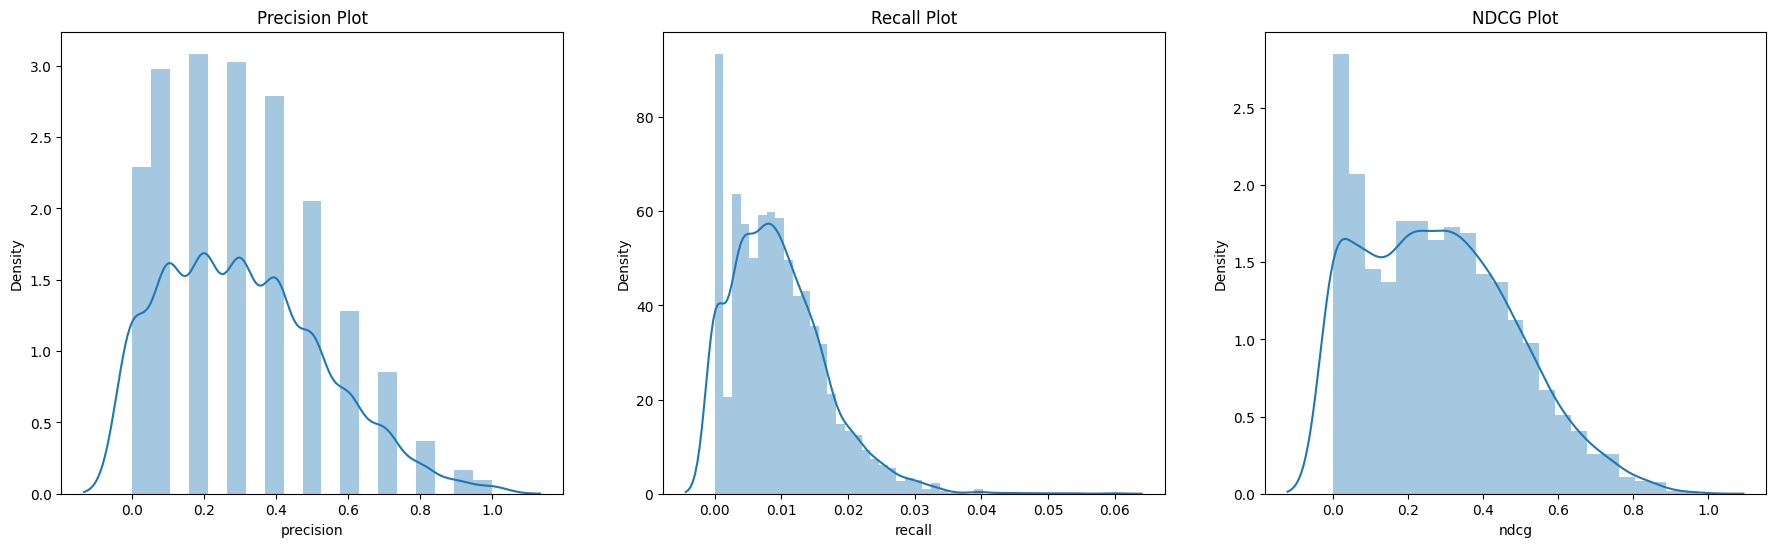

In [61]:
plot_eval(df_eval)

**Recommend by Categories and Mechanics**

In [62]:
# df_bg_cat = df_bg[['name', 'category', 'mechanic']].copy()
# df_bg_cat = df_bg_cat.set_index('name')
# df_dummy = df_bg_cat.copy()

# for col in df_bg_cat.columns:
#     df_dummy = dummies(col,df_dummy)

# content_sim_df = pd.DataFrame(cosine_similarity(df_dummy), columns=df_dummy.index, index=df_dummy.index)
# content_sim_df.head()

In [63]:
# df_eval = evaluate(content_sim_df)
# print("Precision Average:",pd.to_numeric(df_eval['precision']).mean())
# print("Recall Average:",pd.to_numeric(df_eval['recall']).mean())
# print("NDCG:",pd.to_numeric(df_eval['ndcg']).mean())

In [64]:
# plot_eval(df_eval)

**Recommend by Numerical and Categorical Data**

In [65]:
df_num_cat = df_bg_num.join(df_dummy) 
df_num_cat.head()

,rank,weight,minplayers,maxplayers,playingtime,minage,yearpublished,'AbstractStrategy','Action/Dexterity','Adventure',...,'StoryFactory','Litor','NordicGamesehf','Q-Workshop','LouvreEditions','MeeplesCafe','TempoGames(I)','Rabén&Sjögren','ParadigmInfinitumPteLtd','SunTeamDayHobbyCompany'
name,,,,,,,,,,,,,,,,,,,,,
Pandemic,0.017526,0.365776,0.142857,0.04,0.012500,0.444444,0.481481,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Carcassonne,0.031714,0.235571,0.142857,0.05,0.012500,0.388889,0.185185,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Catan,0.071440,0.341509,0.285714,0.04,0.033333,0.555556,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7 Wonders,0.012018,0.344994,0.142857,0.07,0.008333,0.555556,0.555556,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dominion,0.017192,0.352225,0.142857,0.04,0.008333,0.722222,0.481481,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
content_sim_df = pd.DataFrame(cosine_similarity(df_num_cat), columns=df_num_cat.index, index=df_num_cat.index)
content_sim_df.head()

name,Pandemic,Carcassonne,Catan,7 Wonders,Dominion,Ticket to Ride,Codenames,Terraforming Mars,7 Wonders Duel,Agricola,...,RRR,Magic: The Gathering – Heroes of Dominaria Board Game,"Gulf, Mobile & Ohio",1805: Sea of Glory,Steam Donkey,Feierabend,Nations at War: White Star Rising,Oaxaca: Crafts of a Culture,A Gentle Rain,Wizards of the Wild
name,,,,,,,,,,,,,,,,,,,,,
Pandemic,1.000000,0.242351,0.121852,0.396378,0.214777,0.257460,0.253456,0.193348,0.326618,0.312239,...,0.024466,0.079181,0.020297,0.031710,0.110720,0.030112,0.038369,0.028989,0.036792,0.106161
Carcassonne,0.242351,1.000000,0.144710,0.148707,0.369827,0.174148,0.185505,0.188521,0.141682,0.260657,...,0.093822,0.024757,0.056041,0.021719,0.019290,0.018593,0.026797,0.017713,0.074310,0.017659
Catan,0.121852,0.144710,1.000000,0.042576,0.155573,0.098107,0.103950,0.106517,0.012608,0.120700,...,0.020302,0.117444,0.107228,0.109465,0.022619,0.129697,0.083789,0.058874,0.017814,0.061278
7 Wonders,0.396378,0.148707,0.042576,1.000000,0.222445,0.298637,0.191257,0.280066,0.621599,0.184324,...,0.036056,0.056073,0.027376,0.045351,0.199893,0.044608,0.056914,0.091473,0.055216,0.192216
Dominion,0.214777,0.369827,0.155573,0.222445,1.000000,0.188630,0.135546,0.116035,0.159055,0.281849,...,0.031817,0.049068,0.066802,0.040348,0.123003,0.038215,0.052149,0.195516,0.045556,0.076841


In [67]:
df_eval = evaluate(content_sim_df)
print("Precision Average:",pd.to_numeric(df_eval['precision']).mean())
print("Recall Average:",pd.to_numeric(df_eval['recall']).mean())
print("NDCG:",pd.to_numeric(df_eval['ndcg']).mean())

Precision Average: 0.30107597000326053
Recall Average: 0.009300815128790349
NDCG: 0.27645399413107274


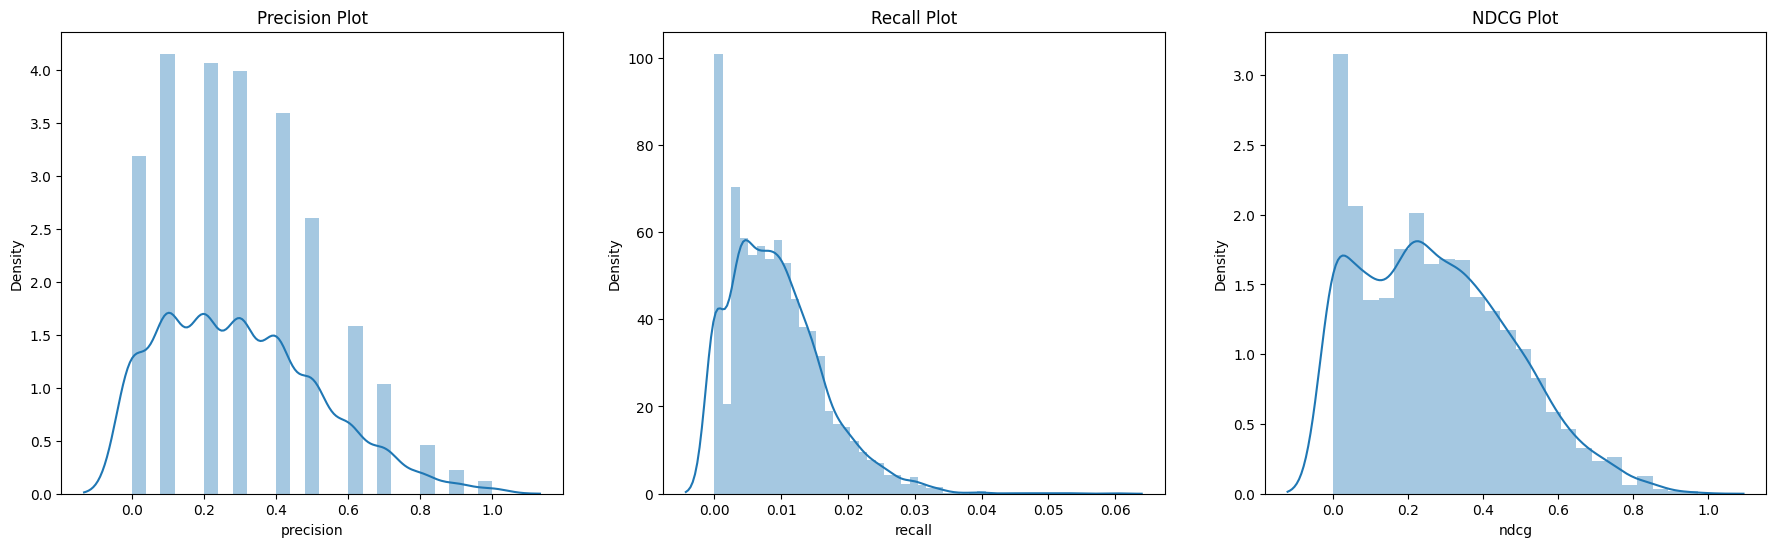

In [68]:
plot_eval(df_eval)